<a href="https://colab.research.google.com/github/danglive/Deep-Learning-tutorial/blob/master/Neural_Machine_Translation_in_TensorFlow_using_TPUs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Machine Translation with TensorFlow
In this tutorial, we'll be going through Neural Machine Translation (NMT) using a Sequence-to-Sequence model (seq2seq)
<br>
Let's begin by downloading the dataset which is a textfile comprising of English and their translated German translations separated by a `\t` (tab)
<br>

In [1]:
!wget http://www.manythings.org/anki/deu-eng.zip

--2019-12-14 13:27:55--  http://www.manythings.org/anki/deu-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.109.196, 104.24.108.196, 2606:4700:30::6818:6dc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.109.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7612057 (7.3M) [application/zip]
Saving to: ‘deu-eng.zip’

deu-eng.zip         100%[===================>]   7.26M  19.3MB/s    in 0.4s    

2019-12-14 13:27:55 (19.3 MB/s) - ‘deu-eng.zip’ saved [7612057/7612057]



In [2]:
# Unzipping the contents of the file
!unzip deu-eng.zip
!ls

Archive:  deu-eng.zip
  inflating: deu.txt                 
  inflating: _about.txt              
_about.txt  deu-eng.zip  deu.txt  sample_data


In [0]:
!rm deu-eng.zip
!mkdir "nmt_data"
!mv deu.txt _about.txt "nmt_data"

In [4]:
!cd nmt_data && ls

_about.txt  deu.txt


In [0]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from numpy import array
import pandas as pd
import string
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [6]:
# Examining the dataset
!head ./nmt_data/deu.txt

Hi.	Hallo!	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)
Hi.	Grüß Gott!	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)
Run!	Lauf!	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #941078 (Fingerhut)
Wow!	Potzdonner!	CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #2122382 (Pfirsichbaeumchen)
Wow!	Donnerwetter!	CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #2122391 (Pfirsichbaeumchen)
Fire!	Feuer!	CC-BY 2.0 (France) Attribution: tatoeba.org #1829639 (Spamster) & #1958697 (Tamy)
Help!	Hilfe!	CC-BY 2.0 (France) Attribution: tatoeba.org #435084 (lukaszpp) & #575889 (MUIRIEL)
Help!	Zu Hülf!	CC-BY 2.0 (France) Attribution: tatoeba.org #435084 (lukaszpp) & #2122375 (Pfirsichbaeumchen)
Stop!	Stopp!	CC-BY 2.0 (France) Attribution: tatoeba.org #448320 (FeuDRenais) & #626467 (jakov)
Wait!	Warte!	CC-BY 2.0 (France) Attribution: tatoeba.org #1744314 (belgavox) & #2122378 (Pfirsichbaeumch

In [7]:
# Extracting and cleaning the data
deu_eng = open('./nmt_data/deu.txt', mode='rt', encoding='utf-8').read().strip().split('\n')
deu_eng = [deu_eng[i].strip().split('\t') for i in range(len(deu_eng))]
deu_eng = array(deu_eng)

# We'll only be working with the first 50000 instances in the dataset for this tutorial
deu_eng = deu_eng[:50000, :]
print (len(deu_eng))
print (deu_eng[:5, :])

50000
[['Hi.' 'Hallo!'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)']
 ['Hi.' 'Grüß Gott!'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)']
 ['Run!' 'Lauf!'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #941078 (Fingerhut)']
 ['Wow!' 'Potzdonner!'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #2122382 (Pfirsichbaeumchen)']
 ['Wow!' 'Donnerwetter!'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #2122391 (Pfirsichbaeumchen)']]


In [8]:
# Removing the punctuation from the phrases
deu_eng[:, 0] = [s.translate((str.maketrans('', '', string.punctuation))) for s in deu_eng[:, 0]]
deu_eng[:, 1] = [s.translate((str.maketrans('', '', string.punctuation))) for s in deu_eng[:, 1]]

# Converting phrases to lowercase
for i in range(len(deu_eng)):
    deu_eng[i, 0] = deu_eng[i, 0].lower()
    deu_eng[i, 1] = deu_eng[i, 1].lower()
    
print (deu_eng[:5])

[['hi' 'hallo'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)']
 ['hi' 'grüß gott'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)']
 ['run' 'lauf'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #941078 (Fingerhut)']
 ['wow' 'potzdonner'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #2122382 (Pfirsichbaeumchen)']
 ['wow' 'donnerwetter'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #2122391 (Pfirsichbaeumchen)']]


In [9]:
#Tokenizing the phrases
def tokenize(phrases):
    """
    Tokenization is a process where you take a phrase and encode it 
    using one-hot encoding or based on its index in a set of vocabulary (used here)
    """
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(phrases)
    
    return tokenizer

eng_tokenizer = tokenize(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_sequence_length = 8 # We are creating a sequence of length 8 and will be feeding it into the model

ger_tokenizer = tokenize(deu_eng[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_sequence_length = 8
print ('English vocabular size: {}'.format(eng_vocab_size))
print ('German vocabular size: {}'.format(ger_vocab_size))

for i in list(eng_tokenizer.word_index.items())[:5]:
    print (i)

English vocabular size: 6361
German vocabular size: 10597
('tom', 1)
('i', 2)
('you', 3)
('is', 4)
('a', 5)


In [0]:
# Converting phrases into sequences
def encode_sequences(tokenizer, sequence_length, lines):
    sequence = tokenizer.texts_to_sequences(lines)
    # Padding the sequence with zeros
    sequence = pad_sequences(sequence, sequence_length, padding="post") # 0s after the actual sequence
    return sequence

In [11]:
# Splitting the dataset into 80% training and 20% testing
train, test = train_test_split(deu_eng, test_size=.2, random_state=12)

x_train = encode_sequences(ger_tokenizer, ger_sequence_length, train[:, 0])
y_train = encode_sequences(eng_tokenizer, eng_sequence_length, train[:, 1])

x_test = encode_sequences(ger_tokenizer, ger_sequence_length, test[:, 0])
y_test = encode_sequences(eng_tokenizer, eng_sequence_length, test[:, 1])

print (x_train.shape, y_train.shape)
print (x_test.shape, x_test.shape)

(40000, 8) (40000, 8)
(10000, 8) (10000, 8)


In [12]:
# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy
if tpu:
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu, steps_per_run=128) # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Initializing the TPU system: 10.71.105.234:8470
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Querying Tensorflow master (grpc://10.71.105.234:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 1152963327089717912)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 17238051080905753074)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 2911845365949702356)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 14197512628816466726)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/de

In [13]:
with strategy.scope():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Embedding(ger_vocab_size, 512, input_length=ger_sequence_length, mask_zero=True))
    model.add(tf.keras.layers.LSTM(512))
    model.add(tf.keras.layers.RepeatVector(eng_sequence_length))
    model.add(tf.keras.layers.LSTM(512, return_sequences=True))
    model.add(tf.keras.layers.Dense(eng_vocab_size, activation='softmax'))
    
    model.compile(
        optimizer=tf.train.RMSPropOptimizer(learning_rate=1e-2),
        loss=tf.keras.losses.sparse_categorical_crossentropy,
        metrics=['sparse_categorical_accuracy']
    )
    
    model.summary()
    
history = model.fit(x_train.astype(np.float32), 
                    y_train.astype(np.float32),
                    epochs=20,
                    steps_per_epoch=50)

model.save_weights('./nmt_model.h5', overwrite=True)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 8, 512)            5425664   
_________________________________________________________________
lstm (LSTM)                  (None, 512)               2099200   
_________________________________________________________________
repeat_vector (RepeatVector) (None, 8, 512)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8, 512)            2099200   
_________________________________________________________________
dense (Dense)              

In [14]:
from pprint import pprint
pprint(history.__dict__)

{'_chief_worker_only': None,
 'epoch': [0,
           1,
           2,
           3,
           4,
           5,
           6,
           7,
           8,
           9,
           10,
           11,
           12,
           13,
           14,
           15,
           16,
           17,
           18,
           19],
 'history': {'loss': [0.1568306541442871,
                      0.01566988468170166,
                      0.007179275751113891,
                      0.005124831199645996,
                      0.004764662981033325,
                      0.004221628904342651,
                      0.0036894094944000242,
                      0.003864203095436096,
                      0.003539203703403473,
                      0.00408209353685379,
                      0.0034389901161193848,
                      0.0034644559025764467,
                      0.0033277583122253416,
                      0.003593774735927582,
                      0.003443630337715149,
                    

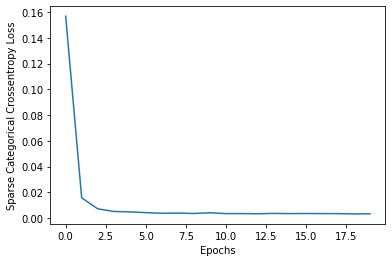

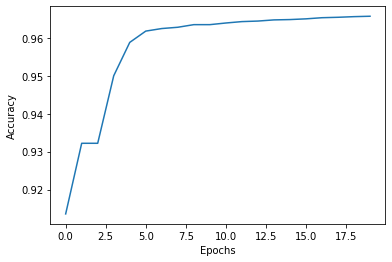

In [15]:
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Sparse Categorical Crossentropy Loss')
plt.show()

plt.plot(history.history['sparse_categorical_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()